<center><h2>Projeto final de Machine Learning</h2></center>
<center><h3>Previsão de receita de filmes</h3></center>
<br />
<center>Alunos: Gabriela Caruso, Guilherme Roccato e Pedro Paulo Telho</center>



# Introdução

<p style="text-align: justify" align="justify">A indústria cinematográfica é reconhecida por suas diversas obras primas. Prêmios como Oscar, Globo de Ouro e Emmy são apenas alguns dos que recompensam os seus atores, diretores, produtores etc. Além disso, muito dinheiro é movimentado tanto em forma de investimento para a produção dos filmes como em forma de receita após o lançamento.</p>

<p style="text-align: justify" align="justify">Nesse contexto, o objetivo do projeto é prever quanto de receita um filme pode gerar para que não se tenha prejuízo durante suas produções.</p>
<p style="text-align: justify" align="justify">Para isso, será criado um modelo de regressão através da base de dados: <a href="https://www.kaggle.com/tmdb/tmdb-movie-metadata/version/2?select=tmdb_5000_movies.csv" >TMDb 5000 movies dataset</a></p>

# Metodologia

<p style="text-align: justify" align="justify">Nessa seção será apresentada a forma em que o modelo foi construído: bibliotecas necessárias, exploração dos dados e técnicas de inferência para definição do melhor modelo de machine learning para o problema.</p>

### Importando bibliotecas necessárias

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### Carregando os dados

In [3]:
movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")

In [4]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [5]:
# movies['overview'][0]

In [6]:
# import json

# json.loads(movies['keywords'][0])[0]['name']

Mesclando créditos e filmes

In [7]:
credits = credits[['movie_id', 'cast', 'crew']]
credits = credits.rename(columns = {'movie_id': 'id'})
movies = pd.merge(movies,credits,on='id',how='left')


In [8]:
movies_copy = movies.copy()

In [9]:
movies_copy.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


### Atenção

Inicialmente excluiremos as colunas que podem ser utilizadas para a análise de textos. O objetivo é começar uma análise simplificada e ir evoluindo com o progresso do projeto.

In [10]:
count = 0
for m in movies_copy['status']:
    if m != 'Released':
        count += 1

print(count)

8


In [11]:
movies_copy = movies_copy.drop(movies_copy[movies_copy.status != 'Released'].index)

In [12]:
count = 0
for m in movies_copy['status']:
    if m != 'Released':
        count += 1

print(count)

0


In [13]:
count = 0
for m in movies_copy['revenue']:
    if m == 0:
        count += 1

print(count)

1420


In [14]:
# movies_copy = movies_copy.drop(movies_copy[movies_copy.revenue == 0].index)

In [15]:
# movies_copy = movies_copy.drop(columns={'homepage', 'id', 'keywords', 'original_title', 'overview', 'production_companies', 'tagline', 'status', 'cast', 'crew'})
movies_copy = movies_copy.drop(columns={'homepage', 'id', 'original_title', 'tagline', 'status', 'crew'})

### Exploração de dados

In [16]:
movies_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4795 entries, 0 to 4802
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4795 non-null   int64  
 1   genres                4795 non-null   object 
 2   keywords              4795 non-null   object 
 3   original_language     4795 non-null   object 
 4   overview              4792 non-null   object 
 5   popularity            4795 non-null   float64
 6   production_companies  4795 non-null   object 
 7   production_countries  4795 non-null   object 
 8   release_date          4794 non-null   object 
 9   revenue               4795 non-null   int64  
 10  runtime               4793 non-null   float64
 11  spoken_languages      4795 non-null   object 
 12  title                 4795 non-null   object 
 13  vote_average          4795 non-null   float64
 14  vote_count            4795 non-null   int64  
 15  cast                 

Como existem apenas 2 filmes sem 'runtime', ou seja, o tempo total de duração do filme, então, iremos retirar essas linhas.

In [17]:
movies_copy = movies_copy.dropna()

In [18]:
movies_copy = movies_copy[(movies_copy[['budget','popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']] != 0).all(axis=1)]

In [19]:
movies_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3226 entries, 0 to 4798
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                3226 non-null   int64  
 1   genres                3226 non-null   object 
 2   keywords              3226 non-null   object 
 3   original_language     3226 non-null   object 
 4   overview              3226 non-null   object 
 5   popularity            3226 non-null   float64
 6   production_companies  3226 non-null   object 
 7   production_countries  3226 non-null   object 
 8   release_date          3226 non-null   object 
 9   revenue               3226 non-null   int64  
 10  runtime               3226 non-null   float64
 11  spoken_languages      3226 non-null   object 
 12  title                 3226 non-null   object 
 13  vote_average          3226 non-null   float64
 14  vote_count            3226 non-null   int64  
 15  cast                 

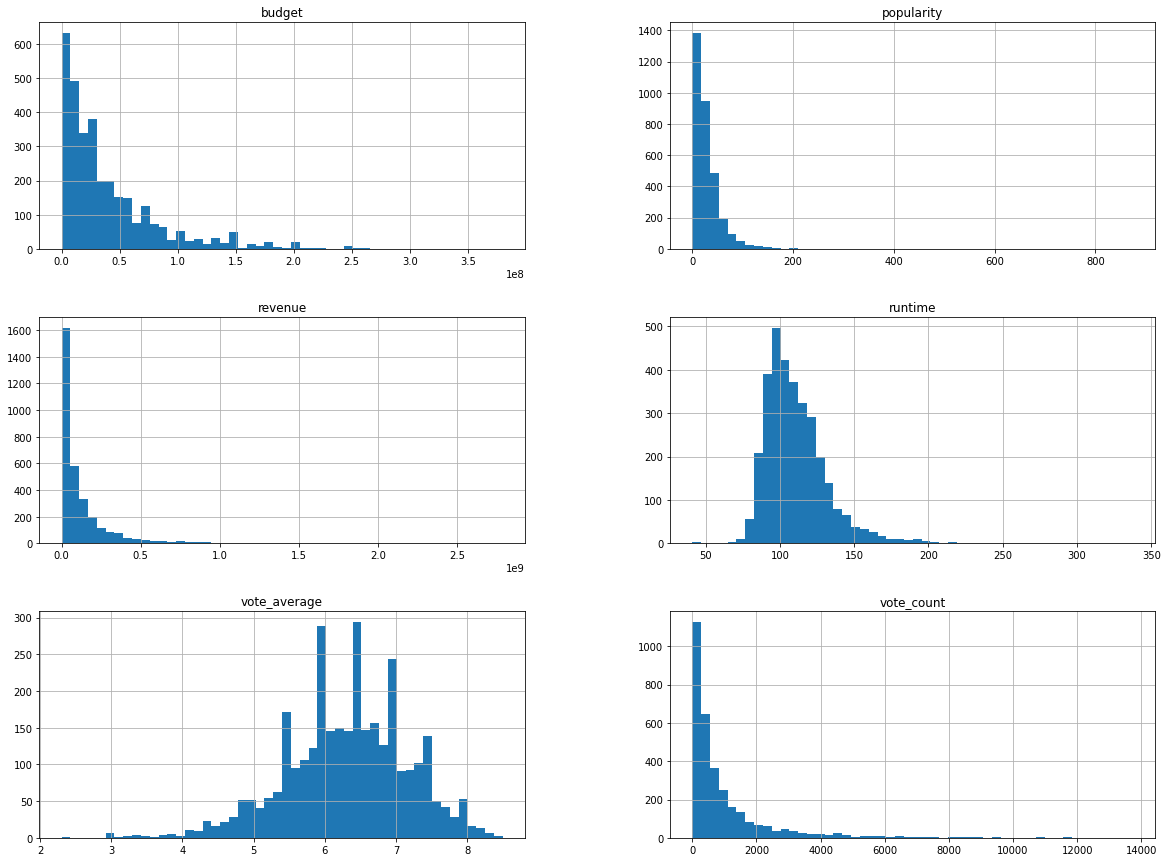

In [20]:
movies_copy.hist(bins=50, figsize=(20, 15))
plt.show()

Visualizando os histogramas acima é possível perceber que não há nenhuma anomalia com a base de dados e, portanto, é posssível continuar com a análise sem nenhuma necessidade de manipulação.

In [21]:
correlation_matrix = movies_copy.corr()

Com a matriz de correlação pode-se inferir também que a receita de cada filme tem maior correlação com a quantidade de votos (0.78)

In [22]:
correlation_matrix

,budget,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.431629,0.705260,0.229717,-0.036087,0.539916
popularity,0.431629,1.000000,0.602063,0.182385,0.288001,0.748965
revenue,0.705260,0.602063,1.000000,0.233235,0.187830,0.756110
runtime,0.229717,0.182385,0.233235,1.000000,0.386253,0.258103
vote_average,-0.036087,0.288001,0.187830,0.386253,1.000000,0.380685
vote_count,0.539916,0.748965,0.756110,0.258103,0.380685,1.000000


### Separação de dados treinamento/teste

Para mantermos a integridade dos dados de treinamento/teste é necessário fazer uma separação estratificada. Nesse sentido, será feita a separação pela variável vote_count.

In [23]:
movies_copy['vote_count'].max()

13752

In [24]:
movies_copy['vote_count'].min()

1

In [25]:
def stratified_shuffle(x):
    if x <= 2751:
        return 1.0
    elif x > 2751 and x <= 5502:
        return 2.0
    elif x > 5502 and x <= 8253:
        return 3.0
    elif x > 8253 and x <= 11004:
        return 4.0
    else:
        return 5.0

In [26]:
movies_copy['vote_count_cat'] = movies_copy['vote_count'].astype(int)

In [27]:
movies_copy['vote_count_cat'] = movies_copy['vote_count'].apply(stratified_shuffle)

In [28]:
movies_copy['vote_count_cat'].value_counts(True)

1.0    0.910725
2.0    0.067576
3.0    0.015809
4.0    0.004650
5.0    0.001240
Name: vote_count_cat, dtype: float64

In [29]:
movies_copy = movies_copy.reset_index()

In [30]:
# Divide, de modo estratificado, o conjunto de dados.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=RANDOM_SEED,
)
for train_index, test_index in split.split(movies_copy, movies_copy['vote_count_cat']):
    strat_train_set = movies_copy.loc[train_index]
    strat_test_set = movies_copy.loc[test_index]

Verificando se a separação estratificada foi bem sucedida:

In [31]:
strat_train_set['vote_count_cat'].value_counts(True)

1.0    0.910853
2.0    0.067442
3.0    0.015891
4.0    0.004651
5.0    0.001163
Name: vote_count_cat, dtype: float64

In [32]:
strat_test_set['vote_count_cat'].value_counts(True)

1.0    0.910217
2.0    0.068111
3.0    0.015480
4.0    0.004644
5.0    0.001548
Name: vote_count_cat, dtype: float64

In [33]:
# Remove a coluna nova, que foi adicionada apenas temporariamente.
strat_train_set.drop(['vote_count_cat'], axis=1, inplace=True)
strat_test_set.drop(['vote_count_cat'], axis=1, inplace=True)

In [34]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2580 entries, 543 to 916
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 2580 non-null   int64  
 1   budget                2580 non-null   int64  
 2   genres                2580 non-null   object 
 3   keywords              2580 non-null   object 
 4   original_language     2580 non-null   object 
 5   overview              2580 non-null   object 
 6   popularity            2580 non-null   float64
 7   production_companies  2580 non-null   object 
 8   production_countries  2580 non-null   object 
 9   release_date          2580 non-null   object 
 10  revenue               2580 non-null   int64  
 11  runtime               2580 non-null   float64
 12  spoken_languages      2580 non-null   object 
 13  title                 2580 non-null   object 
 14  vote_average          2580 non-null   float64
 15  vote_count          

In [35]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 646 entries, 2530 to 2753
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 646 non-null    int64  
 1   budget                646 non-null    int64  
 2   genres                646 non-null    object 
 3   keywords              646 non-null    object 
 4   original_language     646 non-null    object 
 5   overview              646 non-null    object 
 6   popularity            646 non-null    float64
 7   production_companies  646 non-null    object 
 8   production_countries  646 non-null    object 
 9   release_date          646 non-null    object 
 10  revenue               646 non-null    int64  
 11  runtime               646 non-null    float64
 12  spoken_languages      646 non-null    object 
 13  title                 646 non-null    object 
 14  vote_average          646 non-null    float64
 15  vote_count         

### Preparando os dados para o modelo - Separando X e y

In [36]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2580 entries, 543 to 916
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 2580 non-null   int64  
 1   budget                2580 non-null   int64  
 2   genres                2580 non-null   object 
 3   keywords              2580 non-null   object 
 4   original_language     2580 non-null   object 
 5   overview              2580 non-null   object 
 6   popularity            2580 non-null   float64
 7   production_companies  2580 non-null   object 
 8   production_countries  2580 non-null   object 
 9   release_date          2580 non-null   object 
 10  revenue               2580 non-null   int64  
 11  runtime               2580 non-null   float64
 12  spoken_languages      2580 non-null   object 
 13  title                 2580 non-null   object 
 14  vote_average          2580 non-null   float64
 15  vote_count          

In [37]:
strat_train_set['overview'][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

In [38]:
import json

json.loads(strat_train_set['keywords'][0])[0]['name']

'culture clash'

In [39]:
strat_train_set_copy = strat_train_set.drop(columns={'genres', 'keywords', 'original_language', 'overview', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'title', 'cast'})
strat_train_set_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2580 entries, 543 to 916
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         2580 non-null   int64  
 1   budget        2580 non-null   int64  
 2   popularity    2580 non-null   float64
 3   revenue       2580 non-null   int64  
 4   runtime       2580 non-null   float64
 5   vote_average  2580 non-null   float64
 6   vote_count    2580 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 225.8 KB


In [40]:
# Variáveis independentes: dataset original menos a coluna de valores dependentes.
movies = strat_train_set_copy.drop('vote_count', axis=1)

# Variável dependente, também chamada de label.
movies_labels = strat_train_set_copy['vote_count'].copy()

### Construindo modelos preditivos

In [41]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(movies, movies_labels)

LinearRegression()

In [42]:
strat_train_set_copy.head()

,index,budget,popularity,revenue,runtime,vote_average,vote_count
543,564,72000000,28.848187,408247917,106.0,6.4,1599
2236,2675,14000000,27.173470,185438673,125.0,6.6,507
618,641,65000000,43.865294,211780824,95.0,6.2,1685
2085,2456,16000000,7.980632,53977250,129.0,7.4,131
3187,4623,300000,6.473667,8000000,80.0,5.9,124


In [43]:
# Para obter as previsões, basta chamar o método predict()
predicted_labels = lin_reg.predict(movies)
print('Predição: {}'.format(predicted_labels.round(decimals=2)))

# Compare com os valores originais:
print('Original: {}'.format(movies_labels.values.round(decimals=2)))

Predição: [2049.21 1176.48 1525.9  ...  846.59 1119.72  332.28]
Original: [1599  507 1685 ... 1360 1267  206]


In [44]:
from sklearn.metrics import mean_squared_error

movies_predictions = lin_reg.predict(movies)
lin_mse = mean_squared_error(movies_labels, movies_predictions)
lin_rmse = np.sqrt(lin_mse)
print('Regressão linear: RMSE = {:.2f}'.format(lin_rmse))

Regressão linear: RMSE = 705.54


In [45]:
residuo = movies_labels - movies_predictions

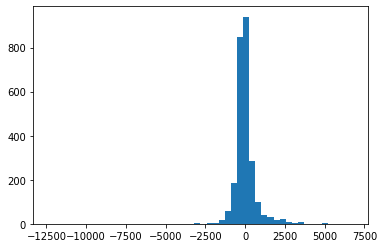

In [46]:
plt.hist(residuo, bins=50);

In [47]:
pd.Series(residuo).describe()

count    2.580000e+03
mean    -5.781284e-14
std      7.056750e+02
min     -1.238652e+04
25%     -3.066359e+02
50%     -8.082513e+01
75%      1.696521e+02
max      6.757024e+03
Name: vote_count, dtype: float64

In [48]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=RANDOM_SEED)
tree_reg.fit(movies, movies_labels)

DecisionTreeRegressor(random_state=42)

In [49]:
predicted_labels = tree_reg.predict(movies)
print('Predição: {}'.format(predicted_labels))
print('Original: {}'.format(movies_labels.values))

Predição: [1599.  507. 1685. ... 1360. 1267.  206.]
Original: [1599  507 1685 ... 1360 1267  206]


In [50]:
movies_predictions = tree_reg.predict(movies)
tree_mse = mean_squared_error(movies_labels, movies_predictions)
tree_rmse = np.sqrt(tree_mse)
print('Regressão linear: RMSE = {:.2f}'.format(tree_rmse))

Regressão linear: RMSE = 0.00


### Melhorando nossa avaliação usando validação cruzada

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    movies,
    movies_labels,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

In [52]:
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
lin_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão linear: RMSE = {:.2f}'.format(lin_rmse))

Regressão linear: RMSE = 886.59


In [53]:
tree_reg.fit(X_train, y_train)

y_pred = tree_reg.predict(X_test)
tree_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão árvore de decisão: RMSE = {:.2f}'.format(tree_rmse))

Regressão árvore de decisão: RMSE = 789.07


In [54]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=RANDOM_SEED)

In [55]:
forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão random forest: RMSE = {:.2f}'.format(forest_rmse))

Regressão random forest: RMSE = 517.69


In [56]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(
    lin_reg,  # modelo
    movies,  # X_train
    movies_labels,  # y_train
    scoring='neg_mean_squared_error',  # metrica de interesse
    cv=10,  # Quantas partições eu quero
    n_jobs=-1,  # Use todos os cores da maquina!
)
lin_rmse_scores = np.sqrt(-lin_scores)


def display_scores(scores):
    print('Scores:', scores.round(decimals=2))
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())


display_scores(lin_rmse_scores)

Scores: [ 539.91  656.49  756.56  713.4   644.43  777.56 1231.72  764.96  582.47
  607.78]
Mean: 727.528931124681
Standard deviation: 184.84758798583943


In [57]:
tree_scores = cross_val_score(
    tree_reg,
    movies,
    movies_labels,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [623.9  864.35 803.23 739.44 988.92 763.56 853.19 760.7  759.51 743.13]
Mean: 789.99087601922
Standard deviation: 91.70307405360809


In [58]:
forest_scores = cross_val_score(
    forest_reg,
    movies,
    movies_labels,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [433.93 603.07 751.63 627.19 652.14 651.67 614.37 595.25 468.05 596.28]
Mean: 599.3579000454904
Standard deviation: 86.2299163784891


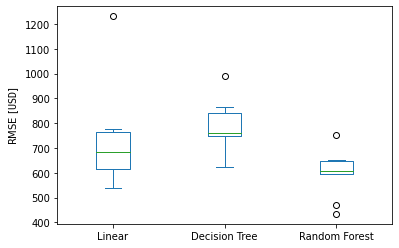

In [59]:
pd.DataFrame({
    'Linear': lin_rmse_scores,
    'Decision Tree': tree_rmse_scores,
    'Random Forest': forest_rmse_scores,
}).plot.box(
    xlabel='Regressor',
    ylabel=r'RMSE $[\mathtt{USD}]$',
    figsize=(6, 4),
);